# Loading all the required packages

In [ ]:
import os
import csv
import re
import nltk
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter

#%pip install transformers
from transformers import pipeline
#from wordcloud import WordCloud, STOPWORDS




nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')




/Users/gaja/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package punkt to /Users/gaja/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/gaja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gaja/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gaja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Exploratory Data Analysis

In [ ]:
df = pd.read_csv('Mavericks.csv')
del df['Unnamed: 0']
df = df.loc[df['language'] == 'en']
del df['language']

In [ ]:
def preprocess(text, stemmer=None, lemmatize=False):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    
    #remove dallas words
    text = re.sub(r'dallas', '', text)
    text = re.sub(r'Dallas', '', text)
    text = re.sub(r'Mavericks', '', text)
    text = re.sub(r'mavericks', '', text)
    text = re.sub(r'MAVS', '', text)
    text = re.sub(r'Mavs', '', text)
    text = re.sub(r'mavs', '', text)

    tokens = word_tokenize(text)

    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    if lemmatize:
        lemmatizer = WordNetLemmatizer()

        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    elif stemmer:
        tokens = [stemmer.stem(token) for token in tokens]

    return " ".join(tokens)

def get_wordnet_pos(token):
    tag = nltk.pos_tag([token])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

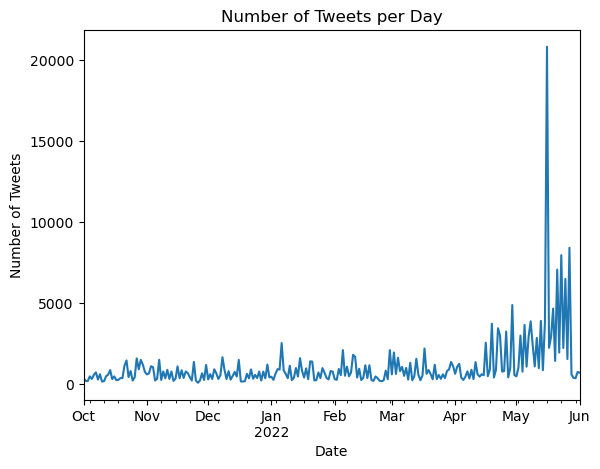

In [ ]:
df_graph = copy(df)

df_graph["Datetime"] = pd.to_datetime(df_graph["Datetime"])
df_graph.set_index('Datetime', inplace=True)
tweets_per_day = df_graph.groupby(pd.Grouper(freq='D')).size()
tweets_per_day.plot(kind='line')

plt.title('Number of Tweets per Day')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')


plt.show()

In [ ]:
df["text_processed_stemmed"] = df["Text"].apply(lambda x: preprocess(x, stemmer=PorterStemmer(), lemmatize=False))
df["text_processed_lemmatized"] = df["Text"].apply(lambda x: preprocess(x, stemmer=None, lemmatize=True))

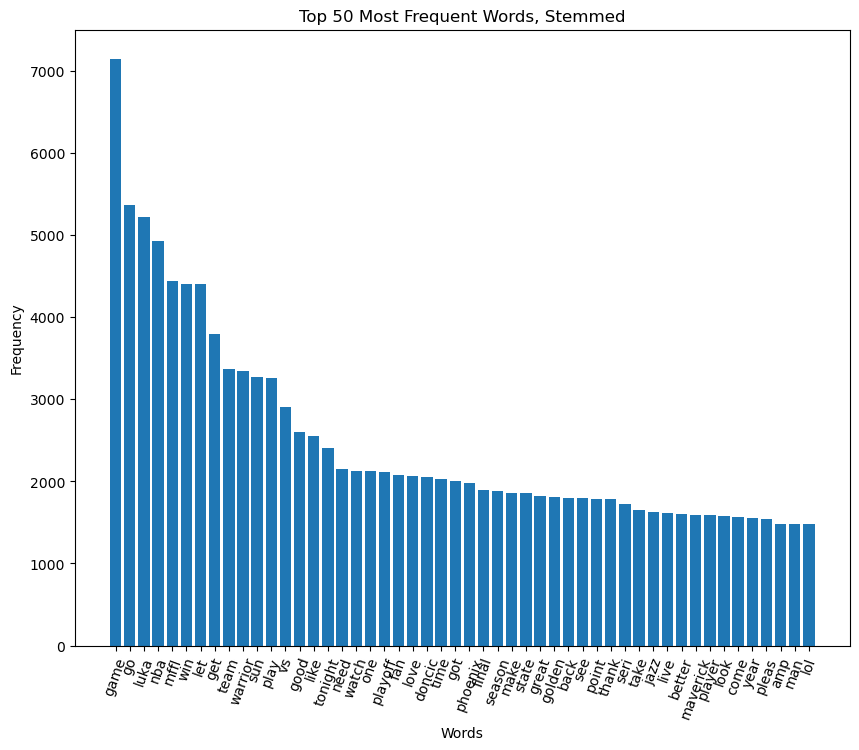

In [ ]:
# vectorize the preprocess text
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["text_processed_stemmed"])

sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:50]

# create a bar plot of the top 50 most frequent words
plt.figure(figsize=(10, 8))
plt.bar([x[0] for x in words_freq], [x[1] for x in words_freq])
plt.xticks(rotation=70)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Most Frequent Words, Stemmed')
plt.show()


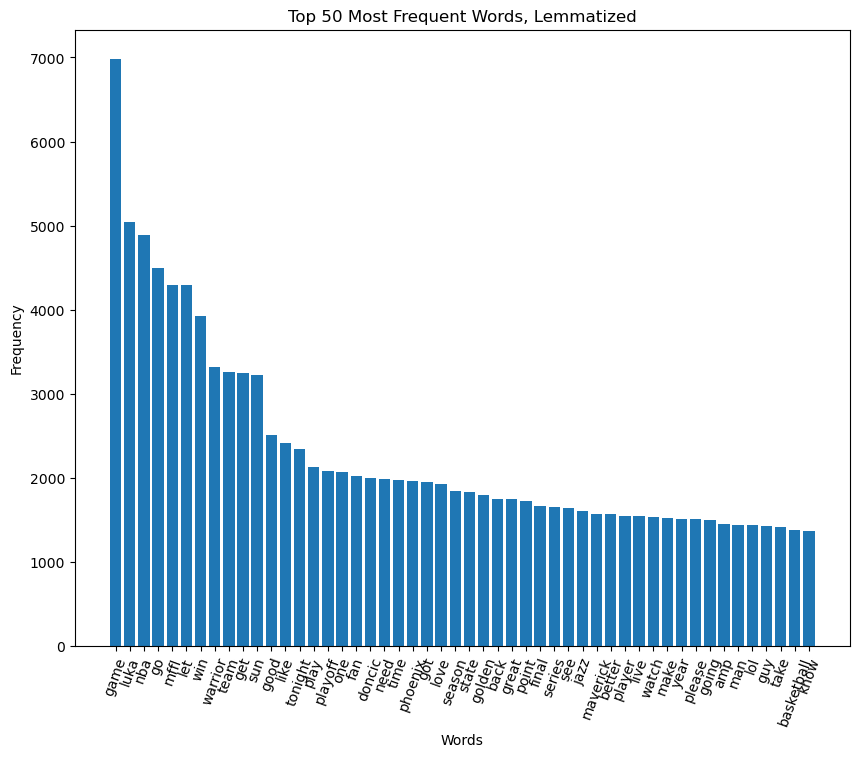

In [ ]:
# vectorize the preprocess text
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["text_processed_lemmatized"])

sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:50]

# create a bar plot of the top 50 most frequent words
plt.figure(figsize=(10, 8))
plt.bar([x[0] for x in words_freq], [x[1] for x in words_freq])
plt.xticks(rotation=70)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Most Frequent Words, Lemmatized')
plt.show()


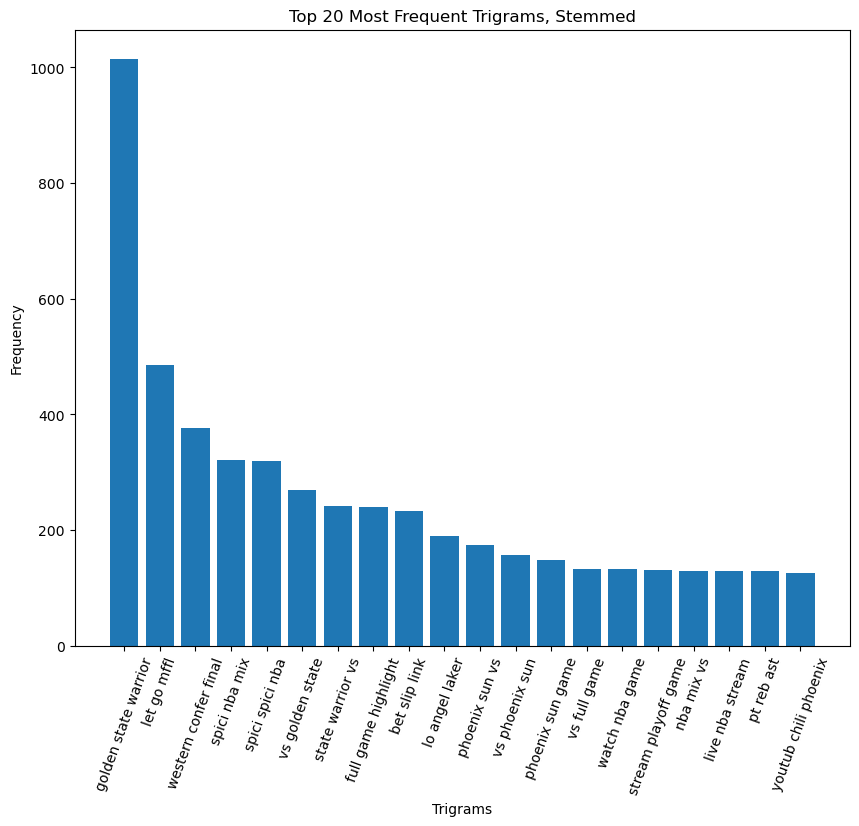

In [ ]:
# Vectorize the preprocessed text considering trigrams (ngram_range=(3, 3))
vectorizer = TfidfVectorizer(ngram_range=(3, 3))
X = vectorizer.fit_transform(df["text_processed_stemmed"])

sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:20]  # change 50 to 20

# Create a bar plot of the top 20 most frequent trigrams
plt.figure(figsize=(10, 8))
plt.bar([x[0] for x in words_freq], [x[1] for x in words_freq])
plt.xticks(rotation=70)
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Trigrams, Stemmed')
plt.show()

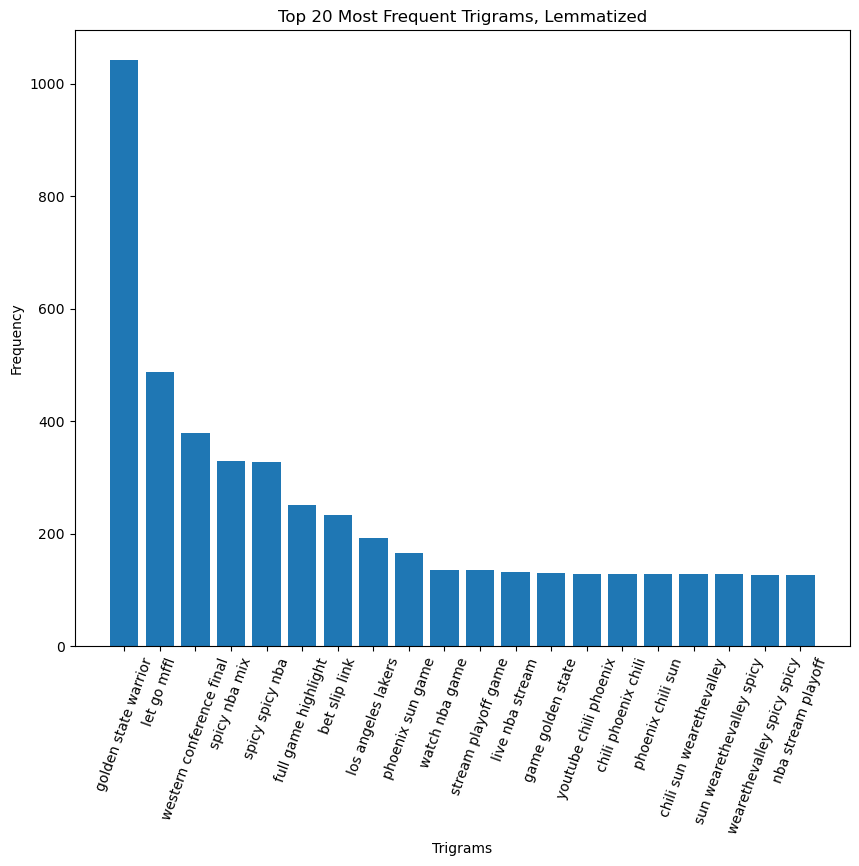

In [ ]:
# Vectorize the preprocessed text considering trigrams (ngram_range=(3, 3))
vectorizer = TfidfVectorizer(ngram_range=(3, 3))
X = vectorizer.fit_transform(df["text_processed_lemmatized"])

sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:20]  # change 50 to 20

# Create a bar plot of the top 20 most frequent trigrams
plt.figure(figsize=(10, 8))
plt.bar([x[0] for x in words_freq], [x[1] for x in words_freq])
plt.xticks(rotation=70)
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Trigrams, Lemmatized')
plt.show()

/var/folders/8r/fnrpr0qn25dgw359fv0145f80000gn/T/ipykernel_52916/2911822608.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_date_tweets["text_processed_stemmed"] = max_date_tweets["Text"].apply(lambda x: preprocess(x, stemmer=PorterStemmer(), lemmatize=False))


Text(0.5, 1.0, 'Top 20 Most Frequent Words on 2022-04-29 04:27:47+00:00')

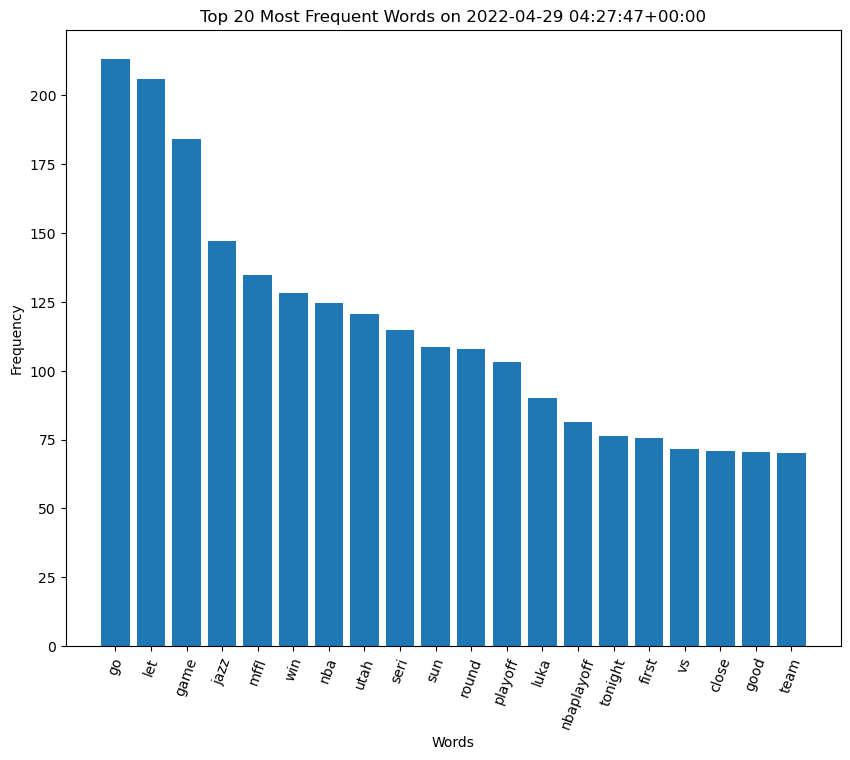

In [ ]:
#20 most frequent words on date with most tweeets (game 7 against suns)
df.Datetime = pd.to_datetime(df.Datetime, format="%Y-%m-%d %H:%M:%S")

tweets_per_date = df.groupby('Datetime').size()

max_date = tweets_per_date.idxmax()


max_date_tweets = df[(df["Datetime"] < max_date + pd.DateOffset(hours=24)) & (df["Datetime"] >= max_date - pd.DateOffset(hours=24))]
max_date_tweets["text_processed_stemmed"] = max_date_tweets["Text"].apply(lambda x: preprocess(x, stemmer=PorterStemmer(), lemmatize=False))
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(max_date_tweets["text_processed_stemmed"])
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:20]

# plot words_freq
plt.figure(figsize=(10, 8))
plt.bar([x[0] for x in words_freq], [x[1] for x in words_freq])
plt.xticks(rotation=70)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words on {}'.format(max_date))


# Sentiment analysis and some exploratory analysis of the sentiment's values (ex: word's frequency)

### Loading data from files without needing to run all cells, standing_date is a dataframe containing the date of the matches thorughout the season together with the partial win-loss metric

In [ ]:
df_tweet = pd.read_csv('Maversicks_processed.csv')
del df_tweet['Unnamed: 0']
df = pd.read_csv('standing_date.csv')
del df['Unnamed: 0']

/var/folders/7l/zjzmbssd2pq6mxggmh9q4c1m0000gn/T/ipykernel_19332/3319731615.py:1: DtypeWarning: Columns (5,6,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tweet = pd.read_csv('Maversicks_processed.csv')


In [ ]:
#computing the sentiment of our tweets using the SentimentIntensityAnalyzer on the lemmatized texts

sia = SentimentIntensityAnalyzer()
df_tweet['text_processed_lemmatized'] = df_tweet['text_processed_lemmatized'].fillna('')
df_tweet['Sentiment'] = df_tweet['text_processed_lemmatized'].apply(lambda X: sia.polarity_scores(X))
#need the compound version as the result of the function is a dictionary
df_tweet['Sentiment_compounded'] = df_tweet['Sentiment'].apply(lambda X: X['compound'])

In [ ]:
#setting the threshold for the sentiment at 0.1 and -0.1, respecitvely
def classify_sentiment(score):
    if score > 0.1: 
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else: 
        return 'Neutral'

In [ ]:
df_tweet['Sentiment_label'] = df_tweet['Sentiment_compounded'].apply(classify_sentiment)

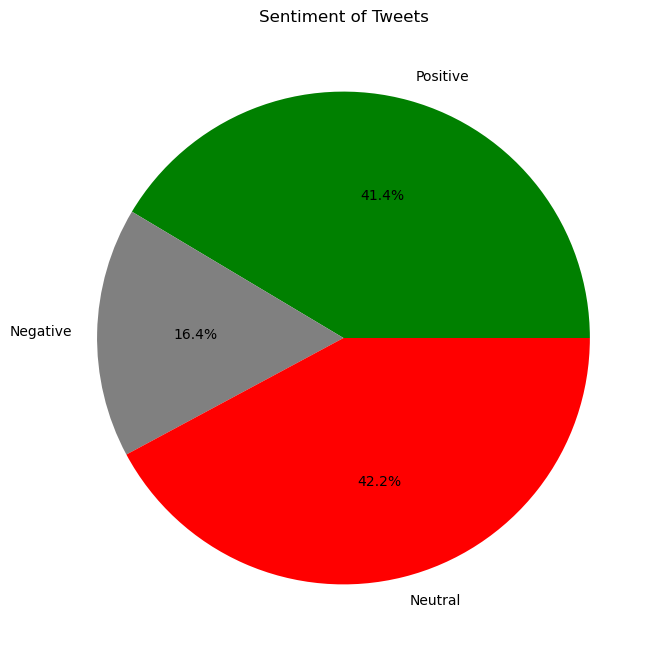

In [ ]:
num_pos = df_tweet[df_tweet['Sentiment_label'] == 'Positive'].shape[0]
num_neg = df_tweet[df_tweet['Sentiment_label'] == 'Negative'].shape[0]
num_neu = df_tweet[df_tweet['Sentiment_label'] == 'Neutral'].shape[0]

plt.figure(figsize=(10, 8))
plt.pie([num_pos, num_neg, num_neu], labels=['Positive', 'Negative', 'Neutral'], colors = ['green', 'grey', 'red'], autopct='%1.1f%%')
plt.title('Sentiment of Tweets')
plt.show()


In [ ]:
df_pos = df_tweet[df_tweet['Sentiment_label'] == 'Positive']
df_neu = df_tweet[df_tweet['Sentiment_label'] == 'Neutral']
df_neg = df_tweet[df_tweet['Sentiment_label'] == 'Negative']

In [ ]:
#getting most frequent words in each of the three sentiment's values
def generate_ngram_counts(df, n=1):
    text = df.text_processed_lemmatized.str.cat(sep=' ')
    tokens = word_tokenize(text)
    return Counter(ngrams(tokens, n))




unigram_counts_pos = generate_ngram_counts(df_pos)
unigram_counts_neu = generate_ngram_counts(df_neu)
unigram_counts_neg = generate_ngram_counts(df_neg)

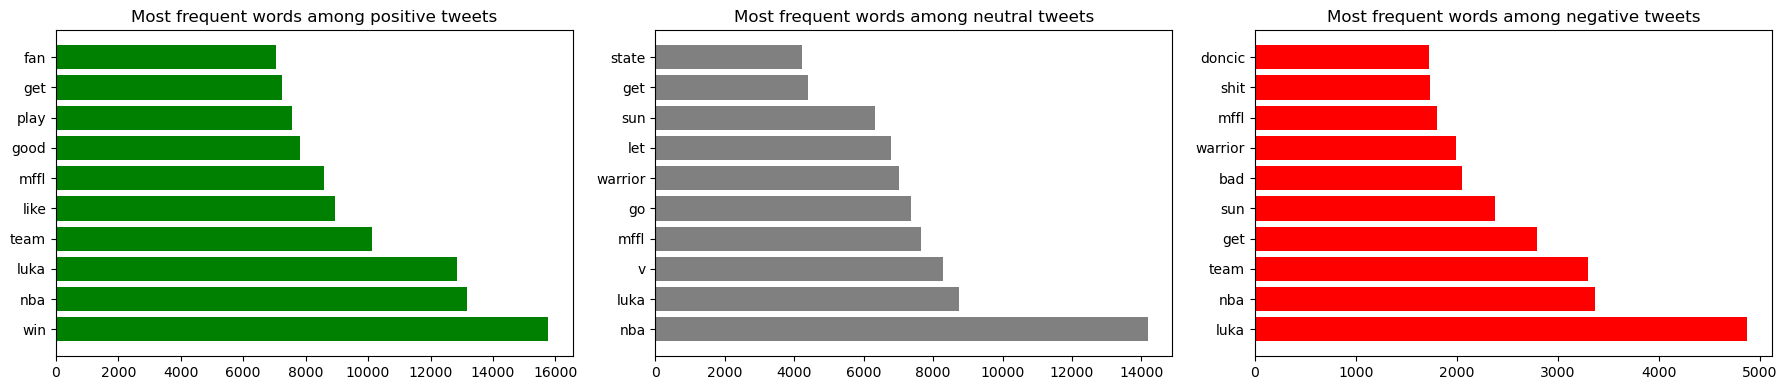

In [ ]:
#plotting the exctrated unigram

# Positive
unigram_labels_pos = [unigram[0][0] for unigram in unigram_counts_pos.most_common(11)][1:]
unigram_counts_pos = [unigram[1] for unigram in unigram_counts_pos.most_common(11)][1:]

# Neutral
unigram_labels_neu = [unigram[0][0] for unigram in unigram_counts_neu.most_common(11)][1:]
unigram_counts_neu = [unigram[1] for unigram in unigram_counts_neu.most_common(11)][1:]

# Negative
unigram_labels_neg = [unigram[0][0] for unigram in unigram_counts_neg.most_common(11)][1:]
unigram_counts_neg = [unigram[1] for unigram in unigram_counts_neg.most_common(11)][1:]

# Plot
fig, axs = plt.subplots(nrows=1, ncols=3, facecolor='w', figsize=(18,4))

# Plot for Positive tweets
axs[0].barh(unigram_labels_pos, unigram_counts_pos, color = 'green')
axs[0].set_title('Most frequent words among positive tweets')

# Plot for Neutral tweets
axs[1].barh(unigram_labels_neu, unigram_counts_neu, color = 'grey')
axs[1].set_title('Most frequent words among neutral tweets')

# Plot for Negative tweets
axs[2].barh(unigram_labels_neg, unigram_counts_neg, color = 'red')
axs[2].set_title('Most frequent words among negative tweets')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
#getting the list of the dates of the matches in order to iterate over it
data_list = [elem for elem in df.Data]
#since it was very granular, we decided to use 1 date out of 2, in order to have broader intervals
data_list2 =[elem for pos, elem in enumerate(data_list) if pos%2 == 0]

In [ ]:
#mean score obtained dividing it by match dates using DATALIST
constant_decrease = 0.45
mean_sent_score = []
for indx, elem in enumerate(data_list):
    list_used = data_list
    list_used_str = 'data_list'
    if indx == 0:
        df_temp = df_tweet.loc[df_tweet.Datetime <= elem]
    elif indx == 1:
        df_temp = df_tweet.loc[(df_tweet.Datetime <= elem) & (df_tweet.Datetime > data_list[indx-1])]    
    else:
        df_temp_prov1 = df_tweet.loc[(df_tweet.Datetime <= elem) & (df_tweet.Datetime > list_used[indx-2])]
        df_temp_prov2 = df_tweet.loc[(df_tweet.Datetime <= list_used[indx-1]) & (df_tweet.Datetime > list_used[indx-2])]
        df_temp_prov2 = df_temp_prov2.copy()
        df_temp_prov2['Sentiment_compounded'] = df_temp_prov2['Sentiment_compounded'] * constant_decrease
        df_temp = pd.concat([df_temp_prov1, df_temp_prov2],axis=0)

    score = df_temp.Sentiment_compounded.apply('mean')

    mean_sent_score.append(score)

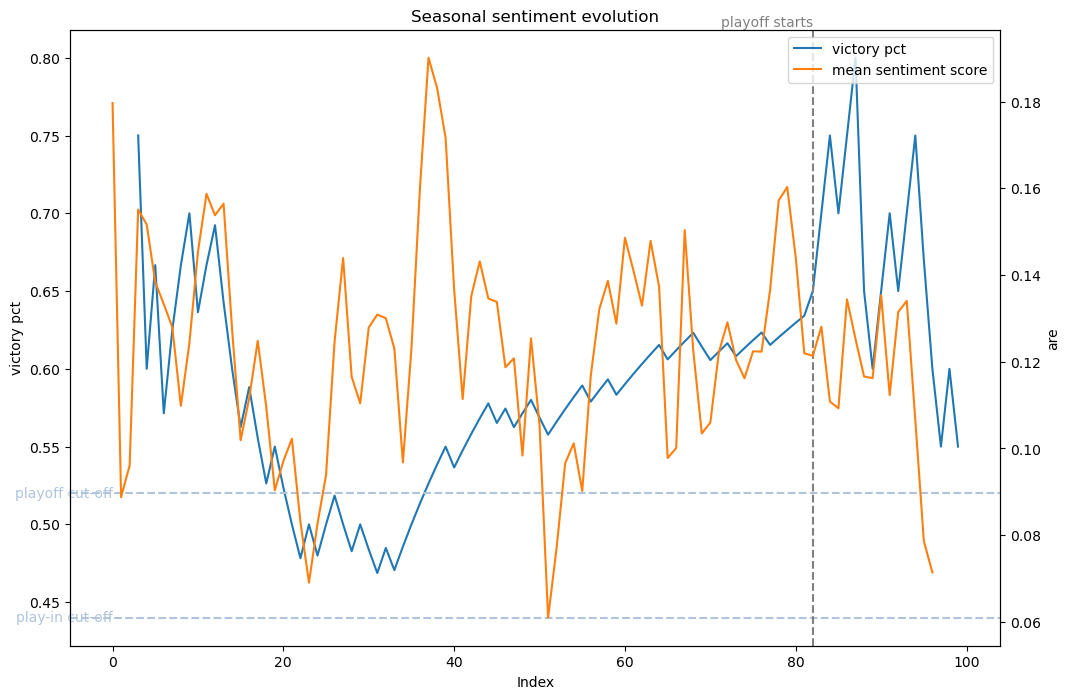

In [ ]:
are = pd.DataFrame(mean_sent_score[:-1])

stretch_factor = len(df['victory pct'][3:]) / len(are)

old_index = np.arange(len(are))
new_index = np.linspace(0, len(are) - 1, int(stretch_factor * len(are)))

stretched_data = np.interp(new_index, old_index, are.values.flatten())
stretched_are = pd.DataFrame(stretched_data)
ax = df['victory pct'][3:].plot(label='victory pct', figsize=(12, 8))
ax2 = stretched_are.plot(secondary_y=True, ax=ax)

ax.set_ylabel('victory pct')
ax.right_ax.set_ylabel('are')
ax.set_xlabel('Index')

plt.title(f'Seasonal sentiment evolution')

# Adding horizontal lines and their comments
ax.axhline(0.44, color='lightsteelblue', linestyle='--')
ax.text(0, 0.44, 'play-in cut-off', color='lightsteelblue', va='center', ha='right')
ax.axhline(0.52, color='lightsteelblue', linestyle='--')
ax.text(0, 0.52, 'playoff cut-off', color='lightsteelblue', va='center', ha='right')

# Adding vertical line and its comment
ax.axvline(82, color='grey', linestyle='--')
ax.text(82, ax.get_ylim()[1], 'playoff starts', color='grey', va='bottom', ha='right')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax.right_ax.get_legend_handles_labels()
ax.legend(lines + lines2, labels + ['mean sentiment score'], loc='upper right')

plt.show()


In [ ]:
#mean score obtained dividing it by match dates using DATALIST2
constant_decrease = 0.45
mean_sent_score = []
for indx, elem in enumerate(data_list2):
    list_used = data_list2
    list_used_str = 'data_list2'
    if indx == 0:
        df_temp = df_tweet.loc[df_tweet.Datetime <= elem]
    elif indx == 1:
        df_temp = df_tweet.loc[(df_tweet.Datetime <= elem) & (df_tweet.Datetime > data_list[indx-1])]    
    else:
        df_temp_prov1 = df_tweet.loc[(df_tweet.Datetime <= elem) & (df_tweet.Datetime > list_used[indx-2])]
        df_temp_prov2 = df_tweet.loc[(df_tweet.Datetime <= list_used[indx-1]) & (df_tweet.Datetime > list_used[indx-2])]
        df_temp_prov2 = df_temp_prov2.copy()
        df_temp_prov2['Sentiment_compounded'] = df_temp_prov2['Sentiment_compounded'] * constant_decrease
        df_temp = pd.concat([df_temp_prov1, df_temp_prov2],axis=0)

    score = df_temp.Sentiment_compounded.apply('mean')

    mean_sent_score.append(score)

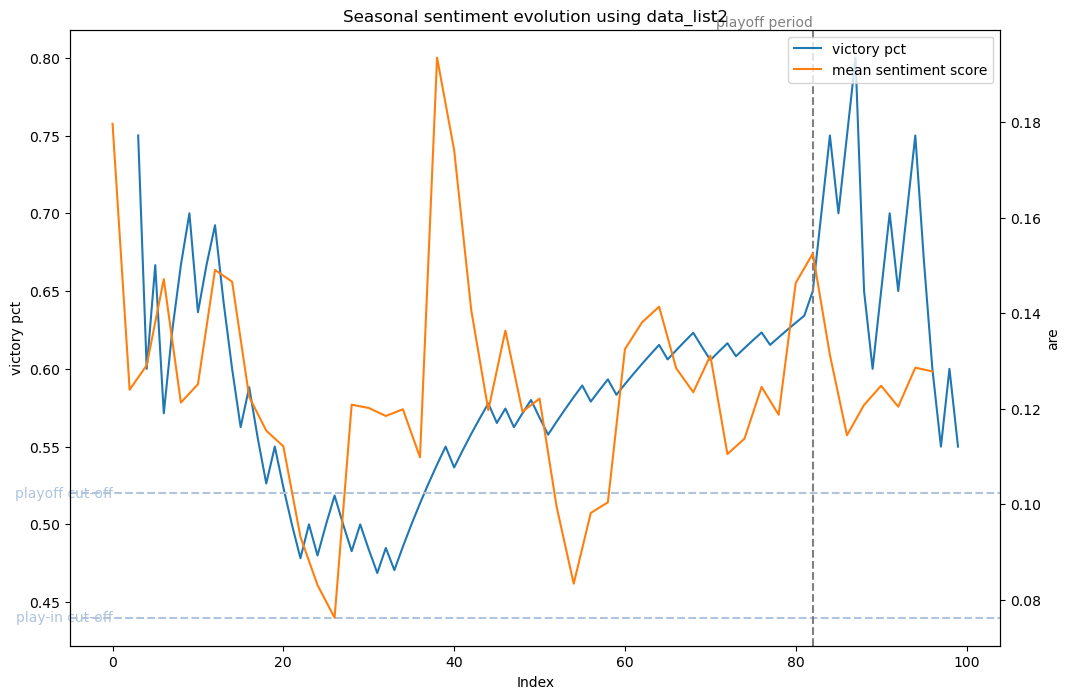

In [ ]:
are = pd.DataFrame(mean_sent_score[:-1])

stretch_factor = len(df['victory pct'][3:]) / len(are)

old_index = np.arange(len(are))
new_index = np.linspace(0, len(are) - 1, int(stretch_factor * len(are)))

stretched_data = np.interp(new_index, old_index, are.values.flatten())
stretched_are = pd.DataFrame(stretched_data)
ax = df['victory pct'][3:].plot(label='victory pct', figsize=(12, 8))
ax2 = stretched_are.plot(secondary_y=True, ax=ax)

ax.set_ylabel('victory pct')
ax.right_ax.set_ylabel('are')
ax.set_xlabel('Index')

plt.title(f'Seasonal sentiment evolution using {list_used_str}')

# Adding horizontal lines and their comments
ax.axhline(0.44, color='lightsteelblue', linestyle='--')
ax.text(0, 0.44, 'play-in cut-off', color='lightsteelblue', va='center', ha='right')
ax.axhline(0.52, color='lightsteelblue', linestyle='--')
ax.text(0, 0.52, 'playoff cut-off', color='lightsteelblue', va='center', ha='right')

# Adding vertical line and its comment
ax.axvline(82, color='grey', linestyle='--')
ax.text(82, ax.get_ylim()[1], 'playoff period', color='grey', va='bottom', ha='right')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax.right_ax.get_legend_handles_labels()
ax.legend(lines + lines2, labels + ['mean sentiment score'], loc='upper right')

plt.show()


### discrepancies:
- peak around 40 -> new year so positive peak
- very low value around 54 -> trade deadline on 10 febraury, mavs sends porzingis out for Dinwiddie (role player but not a star player)
- low value at 72 -> lost against Timberwolves, beated also few days before, lost the possibility to be alone at the fourth place in the ranking

## Extracting Tweets' text from the discepancies' dates

In [ ]:
discr_2 = df_tweet.loc[(df_tweet.Datetime >=  '2022-02-10') & (df_tweet.Datetime <  '2022-02-11 04:00:00')]
discr_2.sample(10, random_state=5).Text.tolist()


["@dallasmavs Say it ain't so we don't need another guard keep KP and get him some help in the front court in Christian Woods Jesus Christ we don't need Spencer Dinwiddie 🤦🏿\u200d♂️",
 '@dallasmavs Luka just had to shed that KP weight 💯',
 'I’m turning in my #MFFL fan card. Good riddance @dallasmavs.',
 'Now that we’ve had a few hours to decompress. How are we feeling @dallasmavs nation?',
 '@dallasmavs Same question https://t.co/djyiNJ4qxB',
 'I like the @dallasmavs - Wizards trade.  I think the Mavs got a great deal!',
 'Cmon Mavs nation, spin this positively for me please. I get the injuries and not being available. But I really wanted KP to succeed in Dallas. 🥺\n@Mavs_FFL @All_Things_Mavs @dallasmavs',
 '@TxQueenTee It would really be backwards for them to trade away kp so they can keep jb then let him walk 😭😭 but that’s really some Dallas mavericks shit',
 'Trade and get Seth Curry back @dallasmavs',
 'Prono NBA 🏀💰\n\n• Dallas Mavericks + Raptors + Memphis Grizzlies win @2,13 5% \

In [ ]:
discr_3 = df_tweet.loc[(df_tweet.Datetime >= '2022-03-26') & (df_tweet.Datetime < '2022-03-27 04:00:00')]
discr_3.sample(10, random_state=5).Text.tolist()

['@dallasmavs @SDinwiddie_25 dirty team',
 '.@dallasmavs STANK AHHH FRANCHISE LIKE WHY ARE YALL LIKE THIS MAN https://t.co/QYflrFgPma',
 'Timberwolves Defeat Dallas Mavericks, 116-95 | March 25, 2022 https://t.co/4YHTtcrhgo @YouTube',
 'Good night @dallasmavs y’all aren’t hustling tonight and I can’t watch #mffl but be back Sunday',
 '@dallasmavs Bag of chips &gt; Kleber...',
 "@dallasmavs  in Minnesota, Mavs played terrible. Go to the basket. Because they couldn't make 3points shots many times. Just make 2points shot more.",
 '226° Jogo - Golden State Warriors 91 x 116 Dallas Mavericks \n\n31 MIN\n18 PTS\n7 REB\n4 AST\n1 STL\n8-23 FG (34.8%)\n1-3 3PT (33.3%)\n1-1 FT (100.0%)\nDerrota ❌ (98-128)\n\n#DubNation https://t.co/9bRkTbftcv',
 'let’s go @dallasmavs @luka7doncic 🏀🙌🏽',
 '@dallasmavs honest question. Are we always on the bad side of officiating lol??',
 'Dangit @dallasmavs \nWhat the hell is this nonsense?']

## Headline generation

In [ ]:
df = pd.read_csv('Maversicks_processed.csv')
standing = pd.read_csv('standing_date.csv')
dates = list(standing['Data'])

/var/folders/7l/zjzmbssd2pq6mxggmh9q4c1m0000gn/T/ipykernel_19332/2583263704.py:1: DtypeWarning: Columns (5,6,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Maversicks_processed.csv')


In [ ]:
#specify the match of which you want to generate the headline (match number)
match_number = 25
temp = df[df["Datetime"].str.contains(dates[match_number-1])]

In [ ]:

def clean_tweet(tweet):
    cleaned_tweet = re.sub(r'@\w+', '', tweet)
    cleaned_tweet = re.sub(r'#\w+', '', cleaned_tweet)
    cleaned_tweet = re.sub(r'http\S+', '', cleaned_tweet)
    cleaned_tweet = re.sub(r'[^\w\s]', '', cleaned_tweet)
    
    cleaned_tweet = cleaned_tweet.lower()
    return cleaned_tweet

temp['cleaned_tweet'] = temp['Text'].apply(clean_tweet)


/var/folders/8r/fnrpr0qn25dgw359fv0145f80000gn/T/ipykernel_52916/2659977689.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['cleaned_tweet'] = temp['Text'].apply(clean_tweet)


### Classification step

In [ ]:
#classifying the tweets in "match" and "other"
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

labels = ['match', 'other']

temp['label'] = [classifier(tweet, labels)['labels'][0] for tweet in temp['cleaned_tweet']]

#keeping only the tweets regarding the match
temp = temp[temp['label']=='match']

### Summarization step

In [ ]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

#loading the transformer to count the number of tokens (max len for the model 1024)
from transformers import BartTokenizer, BartForConditionalGeneration

# Load the tokenizer and model
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

In [ ]:
temp['summary'] = 0
temp['num_tokens'] = 0

for i in range(len(temp)):
  #tokenize the text
  tokens = tokenizer.encode(temp['cleaned_tweet'].iloc[i], add_special_tokens=True)

  #count the number of tokens for each tweet and storing it in the dataframe
  num_tokens = len(tokens)

  #setting the maximum length to the number of tokens in the tweet
  temp['summary'].iloc[i] = summarizer(temp['cleaned_tweet'].iloc[i], max_length = num_tokens, min_length = 0)[0]['summary_text']

  temp['num_tokens'].iloc[i] = len(tokenizer.encode(temp['summary'].iloc[i], add_special_tokens=True))
  

/var/folders/8r/fnrpr0qn25dgw359fv0145f80000gn/T/ipykernel_34318/2389786748.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['summary'].iloc[i] = summarizer(temp['cleaned_tweet'].iloc[i], max_length = num_tokens, min_length = 0)[0]['summary_text']
/var/folders/8r/fnrpr0qn25dgw359fv0145f80000gn/T/ipykernel_34318/2389786748.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['num_tokens'].iloc[i] = len(tokenizer.encode(temp['summary'].iloc[i], add_special_tokens=True))


In [ ]:
#adding . where needed
for i in range(len(temp)):
  if not temp['summary'].iloc[i].endswith('.'):
    temp['summary'].iloc[i] += '.'

In [ ]:
# Defining the function to get the partitions of tweets, since the max length of the inputs for the model is 1024
def get_partitions(df):
  tokens = 0
  partitions = []
  for i in range(len(df)):
    tokens += df['num_tokens'].iloc[i]
    if tokens >= 700:      #se da errore, diminuite il 700
      partitions.append(i-1)
      tokens = df['num_tokens'].iloc[i]
  partitions.insert(0, 0)
  partitions.append(len(df))
  return partitions

partitions = get_partitions(temp)



In [ ]:
def get_summaries(df, partitions):
  headlines = []
  texts = [' '.join(list(df['summary'])[partitions[i]: partitions[i+1]]) for i in range(len(partitions)-1)]
  summaries = [summarizer(text, max_length = 20, min_length = 0)[0]['summary_text'] for text in texts]
  return summaries

headlines = get_summaries(temp, partitions)

headlines

In [ ]:
#defining a baseline
def baseline(df, dates):
  headlines_baseline = []
  for el in dates:
    temp = df[df['Datetime'].str.contains(el)]
    if len(temp[temp['Sentiment_compounded'] > 0]) > len(temp[temp['Sentiment_compounded'] < 0]):
      headlines_baseline.append('Dallas Mavericks won!')
    else:
      headlines_baseline.append('Dallas Mavericks lost')
  return headlines_baseline


headlines_baseline = baseline(df_tweet, dates)
len(headlines_baseline)

100

In [ ]:
baseline_results = pd.DataFrame({'headline_baseline':headlines_baseline, 'match': dates, 'match_number': range(1, len(dates)+1)})
baseline_results

,headline_baseline,match,match_number
0,Dallas Mavericks won!,2021-10-22,1
1,Dallas Mavericks won!,2021-10-24,2
2,Dallas Mavericks won!,2021-10-27,3
3,Dallas Mavericks won!,2021-10-29,4
4,Dallas Mavericks won!,2021-10-30,5
...,...,...,...
95,Dallas Mavericks won!,2022-05-19,96
96,Dallas Mavericks won!,2022-05-21,97
97,Dallas Mavericks won!,2022-05-23,98
98,Dallas Mavericks won!,2022-05-25,99


# Model Evaluation

In [ ]:
original_headlines = pd.read_csv('standing_headlines.csv')
our_headlines = pd.read_csv('our_headlines.csv').drop('Unnamed: 0', axis=1)
baseline = pd.read_csv('baseline_results.csv')

In [ ]:
#selecting the headlines of the matches
original_headlines = original_headlines.iloc[our_headlines['corresponding index']]
baseline = baseline.iloc[our_headlines['corresponding index']]

In [ ]:
print(len(original_headlines))
print(len(baseline))
print(len(our_headlines))

23
23
23


In [ ]:
evaluation = pd.DataFrame({'match number': list(our_headlines['match number']) , 
                           'original_headline': list(original_headlines['headline']), 
                           'generated_headline': list(our_headlines['our headlines']), 
                           'baseline': list(baseline['headline_baseline'])})
evaluation.head(3)


,match number,original_headlines,our_headlines,baseline
0,1,Hawks dominate Mavericks in season opening 113...,The Dallas Mavericks beat the atlanta hawks 84...,Dallas Mavericks won!
1,2,Luka Doncic drops 27 points as Mavs overtake R...,Luka doncic scores 27 as dallas mavericks over...,Dallas Mavericks won!
2,3,Luka Doncic leads Mavs to comeback win over Ro...,The Mavericks won their first home game of the...,Dallas Mavericks won!


In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)

def rouge_score(df):
    rouge_baseline = []
    rouge_our = []
    for i in range(len(df)):
        rouge_baseline.append(scorer.score(df['original_headline'].iloc[i], df['baseline'].iloc[i]))
        rouge_our.append(scorer.score(df['original_headline'].iloc[i], df['generated_headline'].iloc[i]))
    df['rouge_baseline'] = rouge_baseline
    df['rouge_generated'] = rouge_our
    df['precision_baseline'] = [el['rouge1'][0] for el in rouge_baseline]
    df['precision_generated'] = [el['rouge1'][0] for el in rouge_our]
    return df

In [ ]:
rouge_score(evaluation)

,match number,original_headlines,our_headlines,baseline,rouge_baseline,rouge_our,precision_baseline,precision_our
0,1,Hawks dominate Mavericks in season opening 113...,The Dallas Mavericks beat the atlanta hawks 84...,Dallas Mavericks won!,"{'rouge1': (0.3333333333333333, 0.111111111111...","{'rouge1': (0.3076923076923077, 0.444444444444...",0.333333,0.307692
1,2,Luka Doncic drops 27 points as Mavs overtake R...,Luka doncic scores 27 as dallas mavericks over...,Dallas Mavericks won!,"{'rouge1': (0.0, 0.0, 0.0), 'rouge2': (0.0, 0....","{'rouge1': (0.5, 0.5555555555555556, 0.5263157...",0.000000,0.500000
2,3,Luka Doncic leads Mavs to comeback win over Ro...,The Mavericks won their first home game of the...,Dallas Mavericks won!,"{'rouge1': (0.0, 0.0, 0.0), 'rouge2': (0.0, 0....","{'rouge1': (0.0, 0.0, 0.0), 'rouge2': (0.0, 0....",0.000000,0.000000
3,4,Mavericks send Spurs to fourth straight loss,Dallas Mavericks beat San Antonio Spurs 104-99,Dallas Mavericks won!,"{'rouge1': (0.3333333333333333, 0.142857142857...","{'rouge1': (0.25, 0.2857142857142857, 0.266666...",0.333333,0.250000
4,5,"Jokic boosts Nuggets on a bruised knee, beat M...",The Denver Nuggets beat the Dallas Mavericks o...,Dallas Mavericks won!,"{'rouge1': (0.0, 0.0, 0.0), 'rouge2': (0.0, 0....","{'rouge1': (0.3, 0.2727272727272727, 0.2857142...",0.000000,0.300000
5,6,"Luka Doncic hits long 3, Mavericks holds off K...",The Dallas Mavericks beat the kings in the NBA...,Dallas Mavericks won!,"{'rouge1': (0.3333333333333333, 0.090909090909...","{'rouge1': (0.15384615384615385, 0.18181818181...",0.333333,0.153846
6,7,Balanced Heat hold off late Mavericks rally,Dallas Mavericks beat San Antonio Spurs 109-108,Dallas Mavericks won!,"{'rouge1': (0.3333333333333333, 0.142857142857...","{'rouge1': (0.125, 0.14285714285714285, 0.1333...",0.333333,0.125000
7,10,"Mavs overcome slow start, beat Pelicans 108-92",The Chicago Bulls beat the Dallas Mavericks 11...,Dallas Mavericks won!,"{'rouge1': (0.0, 0.0, 0.0), 'rouge2': (0.0, 0....","{'rouge1': (0.1111111111111111, 0.125, 0.11764...",0.000000,0.111111
8,11,Ball and LaVine lead Bulls past Mavericks 117-107,The Dallas Mavericks beat the San Antonio Spur...,Dallas Mavericks won!,"{'rouge1': (0.3333333333333333, 0.111111111111...","{'rouge1': (0.1, 0.1111111111111111, 0.1052631...",0.333333,0.100000
9,12,Spurs bested by the Mavericks once again,Dallas Mavericks take on Denver Nuggets on Sat...,Dallas Mavericks won!,"{'rouge1': (0.3333333333333333, 0.142857142857...","{'rouge1': (0.1111111111111111, 0.142857142857...",0.333333,0.111111


In [ ]:
evaluation.to_csv('evaluation_final.csv')